## 2RPFS Problem (Cmax objective) - Tables and Graphs

Before running this, notebook, please run:

* Notebooks 0.1 and 0.2 (in this order);
* Julia script `calculate_rpfs_budget_worstcase_costs_2rpfs_paper.jl` from project folder `scripts`.
* Julia post-processing script: `src/julia/experiment/calculate_cmax_of_2rpfs_solution_given_nominal_P_bar.jl`

In [1]:
import pandas as pd
import numpy as np
import os, fnmatch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
import glob
import seaborn as sns
import gzip
import matplotlib.style as style
from matplotlib.path import Path
from matplotlib.patches import BoxStyle

%matplotlib inline

In [2]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [3]:
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),

     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     
     ('loosely dashed',        (0, (5, 10))),
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dotted',        (0, (1, 1))),
     ('loosely dotted',        (0, (1, 10)))]

In [4]:
# https://stackoverflow.com/questions/51483901/is-there-a-way-to-extend-the-solid-color-background-to-the-full-width-of-the-pag
class ExtendedTextBox(BoxStyle._Base):
    """
    An Extended Text Box that expands to the axes limits 
                        if set in the middle of the axes
    """

    def __init__(self, pad=0.3, width=500.):
        """
        width: 
            width of the textbox. 
            Use `ax.get_window_extent().width` 
                   to get the width of the axes.
        pad: 
            amount of padding (in vertical direction only)
        """
        self.width=width
        self.pad = pad
        super(ExtendedTextBox, self).__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        x0 and y0 are the lower left corner of original text box
        They are set automatically by matplotlib
        """
        # padding
        pad = mutation_size * self.pad

        # we add the padding only to the box height
        height = height + 2.*pad
        # boundary of the padded box
        y0 = y0 - pad
        y1 = y0 + height
        _x0 = x0
        x0 = _x0 +width /2. - self.width/2.
        x1 = _x0 +width /2. + self.width/2.

        cp = [(x0, y0),
              (x1, y0), (x1, y1), (x0, y1),
              (x0, y0)]

        com = [Path.MOVETO,
               Path.LINETO, Path.LINETO, Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

### List files in the result folder 

In [5]:
resultfolder = os.path.join(os.getcwd(), 'results', 'consolidated')
rpfs_file = os.path.join(resultfolder, '2RPFS_Cmax_all_results_extended.csv')
rpfs_worstcase_file = os.path.join(resultfolder, 'calculate_rpfs_cmax_worstcase_2RPFS_Cmax_all_results.csv')
rpfs_worstcase_paper_file = os.path.join(resultfolder, 'calculate_rpfs_cmax_worstcase_results_paper.csv')
det_file = os.path.join(resultfolder, 'PFSP_Cmax_deterministic_all_results.csv')
stoc_file = os.path.join(resultfolder, 'simgrasp_cmax_ying_stochgrasp_results.csv')

### Create the output folder 

In [6]:
outputfolder = os.path.join(os.getcwd(), 'results', 'consolidated')
outputfolder_graph = os.path.join(os.getcwd(), 'results', 'consolidated', 'graphs')
outputfolder_table = os.path.join(os.getcwd(), 'results', 'consolidated', 'final')
if not os.path.exists(outputfolder_graph):
    os.makedirs(outputfolder_graph)
#print('Saving files on folder: ' + outputfolder)

### Process consolidated CSV result files

In [7]:
df_rpfs = pd.read_csv(rpfs_file, delimiter=';')  # Robust PFSP Budget solutions only
df_rpfs_worstcase = pd.read_csv(rpfs_worstcase_file, delimiter=';')  # Robust PFSP Budget worst-case costs (budget)
df_rpfs_worstcase_paper = pd.read_csv(rpfs_worstcase_paper_file, delimiter=';')  # Robust PFSP Budget worst-case costs (budget)
df_dpfs = pd.read_csv(det_file, delimiter=';')  # Deterministic PFSP, including worst-case costs (budget)
df_stoc = pd.read_csv(stoc_file, delimiter=',')  # Stochastic PFSP (SimGRASP), including worst-case costs (budget)
df_rpfs.drop(columns=['executionId'], inplace=True)
df_rpfs_worstcase.drop(columns=['executionId','model','perc_deviation_p_bar','permutation'], inplace=True)
df_rpfs_worstcase_paper.drop(columns=['executionId','perc_deviation_p_bar','permutation'], inplace=True)
df_dpfs.drop(columns=['executionId'], inplace=True)

**Robust dataframe: calculating new fields.**

In [8]:
df_rpfs['optimal'] = df_rpfs['is_optimal'] & df_rpfs['validated'] & (df_rpfs['gap'] <= 1e-8)
df_rpfs['time_limit'] = 7200.0
df_rpfs['time'] = np.minimum(df_rpfs['time_spent'], df_rpfs['time_limit'])
df_rpfs['gap'] = df_rpfs['gap'] * 100
df_rpfs['RobCost_worstcase'] = df_rpfs['cmax_dp']
df_rpfs = df_rpfs.rename(columns={"budget_Gamma": "RobCost_Gamma", "Gamma1": "RobCost_Gamma1", "Gamma2": "RobCost_Gamma2"})
df_rpfs.head(2)

,model,n,m,alpha,instance_name,RobCost_Gamma1,RobCost_Gamma2,ub_name,RobCost_Gamma,cmax,...,lb,cost,cmax_dp,cut_count,seq,cmax_nominal,optimal,time_limit,time,RobCost_worstcase
0,Wagner,10,2,10,RB0101001.txt,20,20,mip_separation,20 20,285.1,...,285.1,285.1,285.1,-100.0,1,276,True,7200.0,6.34,285.1
1,Wagner,10,2,10,RB0101001.txt,20,40,mip_separation,20 40,285.1,...,285.1,285.1,285.1,-100.0,1,276,True,7200.0,0.11,285.1


In [9]:
df_rpfs_wagner = df_rpfs[(df_rpfs['model'] == 'Wagner')]
df_rpfs_wilson = df_rpfs[(df_rpfs['model'] == 'Wilson')]

In [10]:
df_rpfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   model                  15366 non-null  object 
 1   n                      15366 non-null  int64  
 2   m                      15366 non-null  int64  
 3   alpha                  15366 non-null  int64  
 4   instance_name          15366 non-null  object 
 5   RobCost_Gamma1         15366 non-null  int64  
 6   RobCost_Gamma2         15366 non-null  int64  
 7   ub_name                15366 non-null  object 
 8   RobCost_Gamma          15366 non-null  object 
 9   cmax                   15366 non-null  float64
 10  permutation            15366 non-null  object 
 11  time_spent             15366 non-null  float64
 12  time_to_best_sol       15366 non-null  float64
 13  iterations             15366 non-null  int64  
 14  num_visited_solutions  15366 non-null  int64  
 15  nu

### Checking the Robust PFSP Budget solutions dataframe

In [11]:
df_rpfs.head(2)

,model,n,m,alpha,instance_name,RobCost_Gamma1,RobCost_Gamma2,ub_name,RobCost_Gamma,cmax,...,lb,cost,cmax_dp,cut_count,seq,cmax_nominal,optimal,time_limit,time,RobCost_worstcase
0,Wagner,10,2,10,RB0101001.txt,20,20,mip_separation,20 20,285.1,...,285.1,285.1,285.1,-100.0,1,276,True,7200.0,6.34,285.1
1,Wagner,10,2,10,RB0101001.txt,20,40,mip_separation,20 40,285.1,...,285.1,285.1,285.1,-100.0,1,276,True,7200.0,0.11,285.1


### Obtaining the Robust PFSP Budget robust costs (worst-case scenarios) for all 2RPFS solutions

For all combinations of Gamma1 and Gamma2.

In [12]:
df_rpfs_worstcase.head(2)

,instance_name,alpha,n,m,Gamma1,Gamma2,cmax_star,20 20,20 40,20 60,...,80 20,80 40,80 60,80 80,80 100,100 20,100 40,100 60,100 80,100 100
0,RB0101001.txt,10,10,2,20,20,285.1,285.1,286.5,286.8,...,301.3,301.3,301.3,301.3,301.3,303.6,303.6,303.6,303.6,303.6
1,RB0101001.txt,10,10,2,20,40,285.1,285.1,285.1,287.9,...,301.3,301.3,301.3,301.3,301.3,303.6,303.6,303.6,303.6,303.6


In [13]:
budget_list = []
for g1 in [20, 40, 60, 80, 100]:
    for g2 in [20, 40, 60, 80, 100]:
        budget_list.append('{} {}'.format(g1, g2))

In [14]:
def split_budget_gamma_column(df):
    # new data frame with split value columns 
    new = df["RobCost_Gamma"].str.split(" ", n = 1, expand = True) 
    # making separate first name column from new data frame 
    df["RobCost_Gamma1"]= new[0] 
    # making separate last name column from new data frame 
    df["RobCost_Gamma2"]= new[1] 
    # convert Gamma columns to numeric
    df["RobCost_Gamma1"] = pd.to_numeric(df["RobCost_Gamma1"], errors='coerce')
    df["RobCost_Gamma2"] = pd.to_numeric(df["RobCost_Gamma2"], errors='coerce')
    return df

In [15]:
df_2rpfs_robustcost = pd.melt(df_rpfs_worstcase, id_vars=['n', 'm', 'alpha', 'instance_name', 'cmax_star', 'Gamma1', 'Gamma2'], 
                     value_vars=budget_list, var_name='RobCost_Gamma', value_name='RobCost_worstcase')
df_2rpfs_robustcost = split_budget_gamma_column(df_2rpfs_robustcost)
rpfs_columns = ['n', 'm', 'alpha', 'instance_name', 'Gamma1', 'Gamma2'] # , 'RobCost_Gamma1'] # , 'RobCost_Gamma2']
df_2rpfs_robustcost = df_2rpfs_robustcost.sort_values(rpfs_columns)
df_2rpfs_robustcost

,n,m,alpha,instance_name,cmax_star,Gamma1,Gamma2,RobCost_Gamma,RobCost_worstcase,RobCost_Gamma1,RobCost_Gamma2
0,10,2,10,RB0101001.txt,285.1,20,20,20 20,285.1,20,20
7508,10,2,10,RB0101001.txt,285.1,20,20,20 40,286.5,20,40
15016,10,2,10,RB0101001.txt,285.1,20,20,20 60,286.8,20,60
22524,10,2,10,RB0101001.txt,285.1,20,20,20 80,289.4,20,80
30032,10,2,10,RB0101001.txt,285.1,20,20,20 100,289.4,20,100
...,...,...,...,...,...,...,...,...,...,...,...
157667,200,2,50,RB2005010.txt,9192.0,100,100,100 20,9192.0,100,20
165175,200,2,50,RB2005010.txt,9192.0,100,100,100 40,9192.0,100,40
172683,200,2,50,RB2005010.txt,9192.0,100,100,100 60,9192.0,100,60
180191,200,2,50,RB2005010.txt,9192.0,100,100,100 80,9192.0,100,80


In [16]:
df_2rpfs_robustcost_paper = pd.melt(df_rpfs_worstcase_paper, id_vars=['n', 'm', 'alpha', 'instance_name', 'cmax_star', 'Gamma1', 'Gamma2'], 
                     value_vars=budget_list, var_name='RobCost_Gamma', value_name='RobCost_worstcase')
df_2rpfs_robustcost_paper = split_budget_gamma_column(df_2rpfs_robustcost_paper)
rpfs_columns = ['n', 'm', 'alpha', 'instance_name', 'Gamma1', 'Gamma2'] # , 'RobCost_Gamma1'] # , 'RobCost_Gamma2']
df_2rpfs_robustcost_paper = df_2rpfs_robustcost_paper.sort_values(rpfs_columns)
df_2rpfs_robustcost_paper

,n,m,alpha,instance_name,cmax_star,Gamma1,Gamma2,RobCost_Gamma,RobCost_worstcase,RobCost_Gamma1,RobCost_Gamma2
0,150,2,20,RB1502008.txt,4903.0,20,20,20 20,4903.0,20,20
51,150,2,20,RB1502008.txt,4903.0,20,20,20 40,5135.0,20,40
102,150,2,20,RB1502008.txt,4903.0,20,20,20 60,5324.2,20,60
153,150,2,20,RB1502008.txt,4903.0,20,20,20 80,5465.2,20,80
204,150,2,20,RB1502008.txt,4903.0,20,20,20 100,5547.6,20,100
...,...,...,...,...,...,...,...,...,...,...,...
1070,200,2,50,RB2005010.txt,9192.0,100,100,100 20,9192.0,100,20
1121,200,2,50,RB2005010.txt,9192.0,100,100,100 40,9192.0,100,40
1172,200,2,50,RB2005010.txt,9192.0,100,100,100 60,9192.0,100,60
1223,200,2,50,RB2005010.txt,9192.0,100,100,100 80,9192.0,100,80


### Analyzing the stochastic solutions dataframe (SimGRASP) 

In [17]:
df_stoc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   filename              7500 non-null   object 
 1   simgrasp_instance     7500 non-null   object 
 2   n                     7500 non-null   int64  
 3   m                     7500 non-null   int64  
 4   nehtdist              7500 non-null   object 
 5   beta1                 7500 non-null   float64
 6   beta2                 7500 non-null   float64
 7   seed                  7500 non-null   int64  
 8   rob_pfsp_instance     7500 non-null   object 
 9   alpha                 7500 non-null   int64  
 10  seq                   7500 non-null   int64  
 11  stochsol_sol_id       7500 non-null   int64  
 12  stochsol_cost         7500 non-null   float64
 13  stochsol_exp_cost     7500 non-null   float64
 14  stochsol_time         7500 non-null   float64
 15  stochsol_permutation 

In [18]:
with pd.option_context('display.max_columns', None):
    display(df_stoc.head(2))

,filename,simgrasp_instance,n,m,nehtdist,beta1,beta2,seed,rob_pfsp_instance,alpha,seq,stochsol_sol_id,stochsol_cost,stochsol_exp_cost,stochsol_time,stochsol_permutation,20 20,20 40,20 60,20 80,20 100,40 20,40 40,40 60,40 80,40 100,60 20,60 40,60 60,60 80,60 100,80 20,80 40,80 60,80 80,80 100,100 20,100 40,100 60,100 80,100 100
0,RB0105001_10_2_t_1.0_0.1_124341_outputs.txt,RB0105001,10,2,t,1.0,0.1,124341,RB0101001.txt,10,1,681,276.0,276.560389,0.021498,1 7 5 2 9 3 6 10 4 8,285.1,286.3,290.8,293.6,294.8,291.8,291.8,291.8,293.6,294.8,297.1,297.1,297.1,297.1,297.1,301.3,301.3,301.3,301.3,301.3,303.6,303.6,303.6,303.6,303.6
1,RB0105001_10_2_t_1.0_0.1_126999_outputs.txt,RB0105001,10,2,t,1.0,0.1,126999,RB0101001.txt,10,1,6226,276.0,275.806348,0.306640,10 1 2 9 5 3 6 7 4 8,285.1,285.1,285.1,285.1,285.1,291.8,291.8,291.8,291.8,291.8,297.1,297.1,297.1,297.1,297.1,301.3,301.3,301.3,301.3,301.3,303.6,303.6,303.6,303.6,303.6


### Obtaining the Robust PFSP Budget robust costs (worst-case scenarios) for all SimGRASP solutions

In [19]:
df_stoc['instance_name'] = df_stoc['rob_pfsp_instance']

budget_list = []
for g1 in [20, 40, 60, 80, 100]:
    for g2 in [20, 40, 60, 80, 100]:
        budget_list.append('{} {}'.format(g1, g2))
df_ssgrasp = pd.melt(df_stoc, id_vars=['n', 'm', 'alpha', 'instance_name', 'stochsol_exp_cost', 'stochsol_time'], 
                     value_vars=budget_list, var_name='RobCost_Gamma', value_name='RobCost_worstcase')
df_ssgrasp = split_budget_gamma_column(df_ssgrasp)
df_ssgrasp

,n,m,alpha,instance_name,stochsol_exp_cost,stochsol_time,RobCost_Gamma,RobCost_worstcase,RobCost_Gamma1,RobCost_Gamma2
0,10,2,10,RB0101001.txt,276.560389,0.021498,20 20,285.1,20,20
1,10,2,10,RB0101001.txt,275.806348,0.306640,20 20,285.1,20,20
2,10,2,10,RB0101001.txt,276.380419,0.313507,20 20,285.1,20,20
3,10,2,10,RB0101001.txt,276.283439,0.091118,20 20,285.1,20,20
4,10,2,10,RB0101001.txt,276.391651,0.473086,20 20,285.1,20,20
...,...,...,...,...,...,...,...,...,...,...
187495,200,2,50,RB2005010.txt,6141.769330,9.832385,100 100,9192.0,100,100
187496,200,2,50,RB2005010.txt,6146.353924,2.256638,100 100,9192.0,100,100
187497,200,2,50,RB2005010.txt,6134.523683,4.882766,100 100,9192.0,100,100
187498,200,2,50,RB2005010.txt,6136.209695,8.153730,100 100,9192.0,100,100


Notice we have 25 executions for each instance file (and respective alpha parameter). For result comparison, we will need one worstcase cost per instance and budget_Gamma. For now, we will group by instance file in order to obtain the smallest and largest worstcase costs found after 25 SimGRASP executions. We will call them `Min(25)` and `Max(25)`. 

In [20]:
#df_ssgrasp_min_worstcost = df_ssgrasp.groupby(['n', 'm', 'alpha', 'instance_name', 'stochsol_exp_cost', 'stochsol_time', 
#                                               'budget_Gamma', 'Gamma1', 'Gamma2']).min()
ssgrasp_columns = ['n', 'm', 'alpha', 'instance_name', 'RobCost_Gamma', 'RobCost_Gamma1', 'RobCost_Gamma2']
df_ssgrasp_min_worstcost = df_ssgrasp[df_ssgrasp['RobCost_worstcase'] == df_ssgrasp.groupby(ssgrasp_columns)['RobCost_worstcase']
                                                                                  .transform('min')]
df_ssgrasp_min_worstcost = df_ssgrasp_min_worstcost.sort_values(ssgrasp_columns).drop_duplicates(ssgrasp_columns)
df_ssgrasp_max_worstcost = df_ssgrasp[df_ssgrasp['RobCost_worstcase'] == df_ssgrasp.groupby(ssgrasp_columns)['RobCost_worstcase']
                                                                                  .transform('max')]
df_ssgrasp_max_worstcost = df_ssgrasp_max_worstcost.sort_values(ssgrasp_columns).drop_duplicates(ssgrasp_columns)

display(df_ssgrasp_min_worstcost.tail(4))
display(df_ssgrasp_max_worstcost.tail(4))

,n,m,alpha,instance_name,stochsol_exp_cost,stochsol_time,RobCost_Gamma,RobCost_worstcase,RobCost_Gamma1,RobCost_Gamma2
119976,200,2,50,RB2005010.txt,6128.873667,2.603435,80 20,8924.0,80,20
127476,200,2,50,RB2005010.txt,6128.873667,2.603435,80 40,8979.0,80,40
134976,200,2,50,RB2005010.txt,6128.873667,2.603435,80 60,8979.0,80,60
142499,200,2,50,RB2005010.txt,6135.312456,8.675718,80 80,8994.0,80,80


,n,m,alpha,instance_name,stochsol_exp_cost,stochsol_time,RobCost_Gamma,RobCost_worstcase,RobCost_Gamma1,RobCost_Gamma2
119991,200,2,50,RB2005010.txt,6153.751684,7.335774,80 20,9177.5,80,20
127484,200,2,50,RB2005010.txt,6153.314825,2.748972,80 40,9181.5,80,40
134984,200,2,50,RB2005010.txt,6153.314825,2.748972,80 60,9181.5,80,60
142484,200,2,50,RB2005010.txt,6153.314825,2.748972,80 80,9181.5,80,80


### Obtaining the Robust PFSP Budget robust costs (worst-case scenarios) for all deterministic solutions

In [21]:
df_dpfs.head(2)

,model,n,m,alpha,instance_name,perc_deviation_p_bar,Gamma1,Gamma2,model_name,budget_Gamma,cmax_star,permutation,time_spent,is_optimal,worstcase_cost,worstcase_scenario_m1,worstcase_scenario_m2,seq
0,Wagner,10,2,10,RB0101001.txt,-100,20,20,worst_case_scenario,20 20,248.4,3 10 5 9 7 2 6 1 4 8,0.09,True,286.5,3 9,10 2,1
1,Wagner,10,2,10,RB0101001.txt,-100,20,40,worst_case_scenario,20 40,248.4,3 10 5 9 7 2 6 1 4 8,0.09,True,292.4,3 9,3 10 7 2,1


In [22]:
df_dpfs = df_dpfs.rename(columns={"budget_Gamma": "RobCost_Gamma", "Gamma1": "RobCost_Gamma1", "Gamma2": "RobCost_Gamma2",
                                 "worstcase_cost": "RobCost_worstcase"})
df_dpfs.head(2)

,model,n,m,alpha,instance_name,perc_deviation_p_bar,RobCost_Gamma1,RobCost_Gamma2,model_name,RobCost_Gamma,cmax_star,permutation,time_spent,is_optimal,RobCost_worstcase,worstcase_scenario_m1,worstcase_scenario_m2,seq
0,Wagner,10,2,10,RB0101001.txt,-100,20,20,worst_case_scenario,20 20,248.4,3 10 5 9 7 2 6 1 4 8,0.09,True,286.5,3 9,10 2,1
1,Wagner,10,2,10,RB0101001.txt,-100,20,40,worst_case_scenario,20 40,248.4,3 10 5 9 7 2 6 1 4 8,0.09,True,292.4,3 9,3 10 7 2,1


### Robust dataframe self-join 

Now, lets join the `rpfs` dataframe with itself (inner join). This will be useful to compare Wilson and Wagner models.

In [23]:
join_columns = ['n', 'm', 'alpha', 'instance_name', 'RobCost_Gamma1', 'RobCost_Gamma2']
df_rob_self = pd.merge(df_rpfs, df_rpfs, how='inner', on=join_columns)
df_rob_self = df_rob_self[(df_rob_self['model_x'] != df_rob_self['model_y'])]

In [24]:
df_rob_self

,model_x,n,m,alpha,instance_name,RobCost_Gamma1,RobCost_Gamma2,ub_name_x,RobCost_Gamma_x,cmax_x,...,lb_y,cost_y,cmax_dp_y,cut_count_y,seq_y,cmax_nominal_y,optimal_y,time_limit_y,time_y,RobCost_worstcase_y
1,Wagner,10,2,10,RB0101001.txt,20,20,mip_separation,20 20,285.1,...,285.1,285.1,285.1,-100.0,1,276,True,7200.0,5.48,285.1
2,Wilson,10,2,10,RB0101001.txt,20,20,mip_separation,20 20,285.1,...,285.1,285.1,285.1,-100.0,1,276,True,7200.0,6.34,285.1
5,Wagner,10,2,10,RB0101001.txt,20,40,mip_separation,20 40,285.1,...,285.1,285.1,285.1,-100.0,1,276,True,7200.0,0.08,285.1
6,Wilson,10,2,10,RB0101001.txt,20,40,mip_separation,20 40,285.1,...,285.1,285.1,285.1,-100.0,1,276,True,7200.0,0.11,285.1
9,Wagner,10,2,10,RB0101001.txt,20,60,mip_separation,20 60,285.1,...,285.1,285.1,285.1,-100.0,1,276,True,7200.0,0.08,285.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31820,Wilson,200,2,50,RB2005010.txt,100,60,mip_separation,100 60,9192.0,...,9192.0,9192.0,9192.0,4.0,10,6128,True,7200.0,45.30,9192.0
31823,Wagner,200,2,50,RB2005010.txt,100,80,mip_separation,100 80,9192.0,...,9192.0,9192.0,9192.0,-100.0,10,6128,True,7200.0,6095.16,9192.0
31824,Wilson,200,2,50,RB2005010.txt,100,80,mip_separation,100 80,9192.0,...,9192.0,9192.0,9192.0,4.0,10,6128,True,7200.0,105.88,9192.0
31827,Wagner,200,2,50,RB2005010.txt,100,100,mip_separation,100 100,9192.0,...,9192.0,9192.0,9192.0,-100.0,10,6128,True,7200.0,196.20,9192.0


# Tables

## Table 1. Average worst-case Cmax Wagner 

In [25]:
table = pd.pivot_table(df_rpfs_wagner, values='cmax_dp', index=['RobCost_Gamma1', 'RobCost_Gamma2'], columns=['alpha', 'n'], aggfunc='mean', fill_value=0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(table)

alpha                              10                                     \
n                                 10      20       50       100      150   
RobCost_Gamma1 RobCost_Gamma2                                              
20             20              341.48  668.00  1577.85  3164.13  4680.15   
               40              345.13  672.90  1581.98  3200.86  4784.48   
               60              347.83  677.49  1593.20  3248.79  4866.53   
               80              350.44  680.99  1601.83  3288.72  4932.21   
               100             351.87  683.48  1608.60  3316.28  4972.99   
40             20              346.20  679.74  1615.45  3226.00  4718.38   
               40              349.85  684.08  1616.42  3242.44  4796.13   
               60              352.52  687.69  1619.42  3268.95  4878.18   
               80              354.70  691.19  1625.12  3296.14  4938.49   
               100             355.88  693.40  1630.66  3320.64  4975.31   
60             20              349.90  690.11  1646.12  3281.08  4780.00   
               40              353.48  693.51  1646.12  3289.62  4815.97   
               60              356.15  696.99  1647.26  3304.05  4887.36   
               80              358.33  699.53  1649.40  3319.68  4947.67   
               100             359.51  701.70  1650.92  3336.53  4984.49   
80             20              352.70  698.03  1668.83  3321.94  4833.73   
               40              356.25  701.32  1668.83  3330.40  4858.09   
               60              358.92  704.09  1668.83  3338.67  4896.95   
               80              361.10  706.63  1670.04  3349.20  4954.06   
               100             362.28  708.26  1671.41  3357.62  4990.88   
100            20              354.29  703.10  1683.11  3346.66  4874.10   
               40              357.74  706.39  1683.11  3355.12  4886.42   
               60              360.41  708.99  1683.11  3361.58  4914.53   
               80              362.59  711.06  1683.11  3369.39  4958.09   
               100             363.77  712.69  1684.32  3376.67  4994.88   

alpha                                       20                            \
n                                  200     10      20       50       100   
RobCost_Gamma1 RobCost_Gamma2                                              
20             20              6267.76  352.30  688.20  1624.50  3261.56   
               40              6367.75  359.52  698.80  1642.36  3361.66   
               60              6485.42  366.46  709.12  1676.96  3477.82   
               80              6571.81  373.32  718.10  1710.20  3562.64   
               100             6628.71  377.74  723.86  1731.56  3617.76   
40             20              6364.78  361.74  712.38  1700.80  3390.42   
               40              6425.35  368.94  720.36  1701.64  3415.44   
               60              6494.57  374.28  728.38  1711.88  3483.86   
               80              6571.81  378.98  735.38  1729.62  3562.64   
               100             6628.71  381.92  741.00  1746.56  3617.76   
60             20              6445.79  369.40  733.12  1762.14  3499.96   
               40              6491.55  376.20  739.70  1762.14  3516.38   
               60              6540.03  381.54  746.18  1763.32  3538.52   
               80              6593.20  385.90  751.98  1767.80  3579.56   
               100             6636.12  388.26  756.40  1778.26  3622.82   
80             20              6521.47  376.22  748.96  1807.56  3590.02   
               40              6544.33  381.68  755.54  1807.56  3598.10   
               60              6591.85  387.02  760.74  1807.56  3611.02   
               80              6629.19  391.38  765.46  1808.88  3628.64   
               100             6660.39  393.74  768.94  1811.62  3649.92   
100            20              6571.07  380.42  759.00  1836.12  3645.00   
               40              6586.61  385.08 

## Table 2. Average run time Wagner robust model

In [26]:
table = pd.pivot_table(df_rpfs_wagner, values='time', index=['RobCost_Gamma1', 'RobCost_Gamma2'], columns=['alpha', 'n'], aggfunc='mean', fill_value=0)
table = np.round(table, 2)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(table)

alpha                            10                                        \
n                               10    20    50      100      150      200   
RobCost_Gamma1 RobCost_Gamma2                                               
20             20              0.74  1.08  6.67   47.37  1893.14  4183.49   
               40              0.11  0.35  4.59  172.33  2741.63  5287.34   
               60              0.11  0.24  5.56  115.33  1521.20  1814.04   
               80              0.12  0.18  3.64   63.71   817.52   356.80   
               100             0.08  0.18  1.96   10.80    94.89   308.92   
40             20              0.10  0.24  2.92   44.68  4296.78  5567.19   
               40              0.13  0.31  2.35  276.84  3085.29  3045.87   
               60              0.10  0.23  3.48   94.21  1578.59  1956.40   
               80              0.10  0.30  2.91   43.76   604.38  2461.29   
               100             0.06  0.15  0.98    9.34    40.80   242.19   
60             20              0.11  0.20  3.39   39.98  4532.11  4025.89   
               40              0.14  0.21  4.73   53.67  3725.77  4485.75   
               60              0.11  0.32  2.65   57.83  1644.96  2098.62   
               80              0.12  0.18  1.59   42.04   210.65   793.27   
               100             0.09  0.13  0.94    9.63    22.26    50.14   
80             20              0.09  0.19  1.51   32.28  2344.82  4159.03   
               40              0.17  0.21  2.13   26.62  1676.80  2665.86   
               60              0.10  0.14  2.26   14.62  1571.02   489.86   
               80              0.09  0.15  1.19   19.22   117.11   536.23   
               100             0.08  0.15  0.54    4.27    14.17    22.79   
100            20              0.08  0.13  1.28    8.97    51.09   217.78   
               40              0.06  0.11  0.75    6.42    71.19   121.92   
               60              0.06  0.14  0.90    4.51    20.00    65.69   
               80              0.05  0.12  0.61    4.88    10.75    36.37   
               100             0.05  0.10  0.45    1.90     3.33     8.60   

alpha                            20                                           \
n                               10    20      50       100      150      200   
RobCost_Gamma1 RobCost_Gamma2                                                  
20             20              0.23  1.32   62.23  3222.17  5186.40  6003.96   
               40              0.21  0.87   70.92  5153.01  3127.58  3876.40   
               60              0.25  0.67   40.26  5236.78  2258.80   363.92   
               80              0.13  0.81    8.34   195.74   792.84   242.16   
               100             0.11  0.25    2.31    17.37    49.06   137.60   
40             20              0.19  0.89  194.87  1821.18  6586.01  5538.94   
               40              0.16  1.56   20.25  2967.53  3703.82  3038.59   
               60              0.16  0.92   20.88  2437.42  2286.20   560.74   
               80              0.19  0.41   16.92   193.41   951.85   245.39   
               100             0.11  0.29    2.17    20.95    83.42   790.06   
60             20              0.44  0.68   13.75  2303.09  7200.00  6093.92   
               40              0.39  0.66    7.07   249.63  5188.00  6151.40   
               60              0.16  1.14    8.88   851.70  3696.77  2658.98   
               80              0.16  0.54   40.03   855.47   880.59  1554.38   
               100             0.12  0.18    1.33    18.75    25.77    41.69   
80             20              0.20  0.64   11.24    48.01  6522.36  6509.62   
               40              0.33  0.50   20.93    53.04  3841.58  6142.42   
               60              0.24  0.44    3.36    86.15  4399.81  2816.60   
               80              0.11  0.29    1.57    37.98  1618.96  2378.92   
               100             0.10  0.18    0.66     5.53    20.76    36.19   
100

## Table 3. Performance all instances 

In [27]:
df_rob_self['x_wins_y_time'] = (df_rob_self['time_x'] < df_rob_self['time_y']).astype(int)

## Table 4. Robust price and hedge value

**Note:** the data generated in this Table depends on a post-processing with the Julia script: ``src/julia/experiment/calculate_cmax_of_2rpfs_solution_given_nominal_P_bar.jl``

In [28]:
df_det_d0 = df_dpfs[(df_dpfs['perc_deviation_p_bar'] == 0)]
df_det_hedge = df_det_d0.copy()
df_2rpfs_hedge = df_rpfs_wagner.copy()

#### Important: Filter out instances not solved to optimality (avoids strange trade-off values)

In [29]:
df_2rpfs_hedge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7509 entries, 0 to 7508
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   model                  7509 non-null   object 
 1   n                      7509 non-null   int64  
 2   m                      7509 non-null   int64  
 3   alpha                  7509 non-null   int64  
 4   instance_name          7509 non-null   object 
 5   RobCost_Gamma1         7509 non-null   int64  
 6   RobCost_Gamma2         7509 non-null   int64  
 7   ub_name                7509 non-null   object 
 8   RobCost_Gamma          7509 non-null   object 
 9   cmax                   7509 non-null   float64
 10  permutation            7509 non-null   object 
 11  time_spent             7509 non-null   float64
 12  time_to_best_sol       7509 non-null   float64
 13  iterations             7509 non-null   int64  
 14  num_visited_solutions  7509 non-null   int64  
 15  num_

In [30]:
### df_2rpfs_hedge = df_2rpfs_hedge[(df_2rpfs_hedge['optimal'] == True)]

In [31]:
join_columns = ['n', 'm', 'alpha', 'instance_name', 'RobCost_Gamma1', 'RobCost_Gamma2']

In [32]:
df_det_hedge = df_det_hedge.rename(columns={"cmax_star": "Cmax_sigma_det_star", "RobCost_worstcase": "RobCost_sigma_det_star"})

In [33]:
df_det_hedge = df_det_hedge[join_columns + ['Cmax_sigma_det_star', 'RobCost_sigma_det_star']]

In [34]:
df_2rpfs_hedge = df_2rpfs_hedge.rename(columns={'cmax_dp': 'RobCost_sigma_rob_star', 
                                                'cmax_nominal': 'Cmax_nominal_sigma_rob'})

In [35]:
df_2rpfs_hedge = df_2rpfs_hedge[join_columns + ['RobCost_sigma_rob_star', 'Cmax_nominal_sigma_rob', 'seq']]

In [36]:
df_det_rob = pd.merge(df_det_hedge, df_2rpfs_hedge, how='inner', on=join_columns)

In [37]:
df_det_rob.head()

,n,m,alpha,instance_name,RobCost_Gamma1,RobCost_Gamma2,Cmax_sigma_det_star,RobCost_sigma_det_star,RobCost_sigma_rob_star,Cmax_nominal_sigma_rob,seq
0,10,2,10,RB0101001.txt,20,20,276.0,290.6,285.1,276,1
1,10,2,10,RB0101001.txt,20,40,276.0,292.1,285.1,276,1
2,10,2,10,RB0101001.txt,20,60,276.0,293.4,285.1,276,1
3,10,2,10,RB0101001.txt,20,80,276.0,296.0,285.1,276,1
4,10,2,10,RB0101001.txt,20,100,276.0,296.0,285.1,276,1


In [38]:
df_det_rob['eta'] = df_det_rob['Cmax_nominal_sigma_rob'] - df_det_rob['Cmax_sigma_det_star']

In [39]:
df_det_rob['H'] = df_det_rob['RobCost_sigma_det_star'] - df_det_rob['RobCost_sigma_rob_star']

In [40]:
df_det_rob['H'] = np.round(np.abs(df_det_rob['H']), 1)
df_det_rob['eta'] = np.round(np.abs(df_det_rob['eta']), 1)

In [41]:
df_det_rob.head(25)

,n,m,alpha,instance_name,RobCost_Gamma1,RobCost_Gamma2,Cmax_sigma_det_star,RobCost_sigma_det_star,RobCost_sigma_rob_star,Cmax_nominal_sigma_rob,seq,eta,H
0,10,2,10,RB0101001.txt,20,20,276.0,290.6,285.1,276,1,0.0,5.5
1,10,2,10,RB0101001.txt,20,40,276.0,292.1,285.1,276,1,0.0,7.0
2,10,2,10,RB0101001.txt,20,60,276.0,293.4,285.1,276,1,0.0,8.3
3,10,2,10,RB0101001.txt,20,80,276.0,296.0,285.1,276,1,0.0,10.9
4,10,2,10,RB0101001.txt,20,100,276.0,296.0,285.1,276,1,0.0,10.9
5,10,2,10,RB0101001.txt,40,20,276.0,295.9,291.8,276,1,0.0,4.1
6,10,2,10,RB0101001.txt,40,40,276.0,297.3,291.8,276,1,0.0,5.5
7,10,2,10,RB0101001.txt,40,60,276.0,297.3,291.8,276,1,0.0,5.5
8,10,2,10,RB0101001.txt,40,80,276.0,297.3,291.8,276,1,0.0,5.5
9,10,2,10,RB0101001.txt,40,100,276.0,297.3,291.8,276,1,0.0,5.5


In [42]:
df_det_rob.to_csv(os.path.join(outputfolder_table, '2rpfs_robustprice_hedge.csv'), sep=',')

In [43]:
#df_det_rob[df_det_rob['instance_name'] == 'RB0205010.txt']  # 'RB2005010.txt', 'RB1502008.txt'
df_ = df_det_rob[(df_det_rob['n'] == 150) & (df_det_rob['seq'] == 8)]
piv = pd.pivot_table(df_, columns=['n', 'seq', 'RobCost_Gamma1', 'RobCost_Gamma2', 'alpha'], values=['eta', 'H'],
                       aggfunc={'eta' : ['mean'], 'H' : 'mean'})  # , margins=True, fill_value=0)
piv.to_csv(os.path.join(outputfolder_table, '2rpfs_robustprice_hedge_test.csv'), sep=',')

In [45]:
df_det_rob[(df_det_rob['instance_name'] == 'RB1504008.txt')]

,n,m,alpha,instance_name,RobCost_Gamma1,RobCost_Gamma2,Cmax_sigma_det_star,RobCost_sigma_det_star,RobCost_sigma_rob_star,Cmax_nominal_sigma_rob,seq,eta,H
5925,150,2,40,RB1504008.txt,20,20,4623.0,5616.8,5183.0,4623,8,0.0,433.8
5926,150,2,40,RB1504008.txt,20,40,4623.0,5834.6,5647.0,4623,8,0.0,187.6
5927,150,2,40,RB1504008.txt,20,60,4623.0,6059.6,6025.4,4623,8,0.0,34.2
5928,150,2,40,RB1504008.txt,20,80,4623.0,6307.4,6307.4,4631,8,8.0,0.0
5929,150,2,40,RB1504008.txt,20,100,4623.0,6472.2,6472.2,4623,8,0.0,0.0
5930,150,2,40,RB1504008.txt,40,20,4623.0,5992.4,5465.0,4625,8,2.0,527.4
5931,150,2,40,RB1504008.txt,40,40,4623.0,6171.8,5647.0,4623,8,0.0,524.8
5932,150,2,40,RB1504008.txt,40,60,4623.0,6234.2,6025.4,4623,8,0.0,208.8
5933,150,2,40,RB1504008.txt,40,80,4623.0,6307.4,6307.4,4623,8,0.0,0.0
5934,150,2,40,RB1504008.txt,40,100,4623.0,6472.2,6472.2,4644,8,21.0,0.0


In [42]:
df_grouped = df_rpfs_wagner.groupby(['alpha', 'n', 'm', 'RobCost_Gamma']).agg({'cmax_dp' : ['count']}).reset_index()
df_grouped.columns = [ ' '.join(str(i) for i in col) for col in df_grouped.columns]
#df_grouped.reset_index(inplace=True)
df_grouped

,alpha,n,m,RobCost_Gamma,cmax_dp count
0,10,10,2,100 100,10
1,10,10,2,100 20,10
2,10,10,2,100 40,10
3,10,10,2,100 60,10
4,10,10,2,100 80,10
...,...,...,...,...,...
745,50,200,2,80 100,10
746,50,200,2,80 20,10
747,50,200,2,80 40,10
748,50,200,2,80 60,10


# Graphs

### Build a dataframe joining the `df_rpfs` and `df_dpfs`

In [43]:
join_columns = ['n', 'm', 'alpha', 'instance_name', 'Gamma1', 'Gamma2']
df_det_d0 = df_dpfs[(df_dpfs['perc_deviation_p_bar'] == 0)]
df_det_d100 = df_dpfs[(df_dpfs['perc_deviation_p_bar'] == 100)]
# join robust and deterministic dfs
#df_join_rob_det = pd.merge(df_rpfs, df_det_d0, how='inner', on=join_columns, suffixes=('_rob', '_d0'))
#df_join_rob_det = pd.merge(df_join_rob_det, df_det_d100, how='inner', on=join_columns, suffixes=('_d0', '_d100'))

### Build a dataframe concatenating `df_rpfs` and `df_dpfs`

In [44]:
def plot_worstcase_comparison(n, instance_name, palette, df_dict, prefix, suffix, enable_markers=True):
    # https://seaborn.pydata.org/tutorial/aesthetics.html
    concat_columns = ['instance_name', 'RobCost_Gamma1', 'RobCost_Gamma2', 'RobCost_Gamma', 'RobCost_worstcase']
    for key, df_i in df_dict.items():
        df_i = df_i[concat_columns]
        df_i['Method'] = key
        df_dict[key] = df_i
    df = pd.concat(df_dict.values())
    df = df[(df['instance_name'] == instance_name)]
    df['RobCost_Gamma1'] = (df['RobCost_Gamma1']).map(int)
    df['RobCost_Gamma2'] = (df['RobCost_Gamma2']).map(int)
    df['budget_f'] = '(' + df['RobCost_Gamma1'].map(str) + ',' + df['RobCost_Gamma2'].map(str) + ')'
    # https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib
    #fig, ax = plt.subplots()
    # the size of A4 paper
    #fig.set_size_inches(11.7, 8.27)
    markers = None
    linestyles = None
    if enable_markers:
        marker = ['*', '+', 'o', 'x', '^', '8', 's', 'p', 'D']
        marker = marker[::-1]
        markers = [marker[i] for i in range(len(df["Method"].unique()))]
        linestyle = ['--', '-.', ':', 'dashed', 'dashdot', 'dotted', 'solid', '-', '-.', '']
        linestyles = [linestyle[i] for i in range(len(df["Method"].unique()))]
    a4_dims = (12, 8.27)
    plt.figure(figsize=a4_dims)
    with sns.axes_style("whitegrid"):
        sns.set_context("paper", font_scale=1.2, rc={"grid.linewidth": 2})
        if enable_markers:
            g = sns.catplot(x="budget_f", y="RobCost_worstcase", linestyles=linestyles, markers=markers,
                            #dashes=[linestyle_tuple[i][1][1] for i in range(len(linestyle_tuple))],
                     hue="Method", kind="point", style="Method", 
                     data=df,
                     height=5, # make the plot 5 units high
                     aspect=3,  # height should be three times width
                     legend=False, palette=palette,
                     row_order=df['budget_f'])
        else:
            g = sns.catplot(x="budget_f", y="RobCost_worstcase", 
                     hue="Method", kind="point", style="Method", 
                     data=df,
                     height=5, # make the plot 5 units high
                     aspect=3,  # height should be three times width
                     legend=False, palette=palette,
                     row_order=df['budget_f'])
        plt.legend(loc='lower right')
        # Remove the '.txt' at the end of instance_name
        instance_name = instance_name[:instance_name.rfind('.txt')]
        g.set_axis_labels(r'Protection level ($\Gamma_{1}\%, \Gamma_{2}\%$)', r'Robust cost : $Z(\sigma)$')
        plt.grid(which='major', axis='x')
        plt.grid(which='minor', axis='y')
        # ============== Special trick to make the suptitle with large backgrounds
        # register the custom style
        BoxStyle._style_list["ext"] = ExtendedTextBox
        title = plt.suptitle(prefix + ' Instance ' + instance_name + ' ' + suffix, fontsize=14, fontweight='bold', 
                             position=(.5, 1.04), backgroundcolor='#d3d3d3', color='black')
        # set the box style of the title text box to our custom box
        bb = title.get_bbox_patch()
        fig = g.fig
        def resize(event):
            # use the figure width as width of the text box 
            bb.set_boxstyle("ext", pad=0.4, width=fig.get_size_inches()[0]*fig.dpi )
        resize(None)
        # =========================================================================
        plt.show()
        g.savefig(os.path.join(outputfolder_graph, 'worstcase_{}.pdf'.format(instance_name)))
        #g.savefig(os.path.join(outputfolder_graph, 'worstcase_{}.pgf'.format(instance_name)))

### Worstcase cost : Small Uncertainty Range Instance - Example 

Alpha = 10% and n = 50

TODO Comparar também com o RobPFSP - Minimax Regret

<Figure size 864x595.44 with 0 Axes>

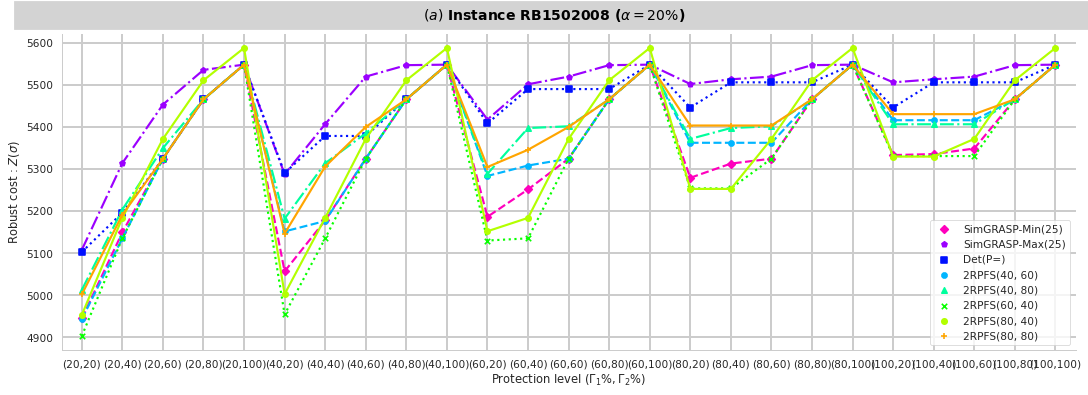

In [45]:
####filename = 'RB0102005.txt'
#filename = 'RB0501003.txt'  # Small Uncertainty range
#filename = 'RB0201009.txt'  # Small Uncertainty range
#filename = 'RB1001007.txt'  # Small Uncertainty range
#filename = 'RB1501006.txt'  # Small Uncertainty range
n = 150
filename = 'RB1502008.txt' # 'RB1502001.txt', 'RB1502006.txt', 'RB1502009.txt', 'RB1502010.txt'
# filename = 'RB0201007.txt'
#filename = 'RB0105010.txt'  # Large Uncertainty range

result_dict = dict()

result_dict['SimGRASP-Min(25)'] = df_ssgrasp_min_worstcost.sort_values(by=['RobCost_Gamma1', 'RobCost_Gamma2'])
result_dict['SimGRASP-Max(25)'] = df_ssgrasp_max_worstcost.sort_values(by=['RobCost_Gamma1', 'RobCost_Gamma2'])
result_dict['Det(P=)'] = df_det_d0.sort_values(by=['RobCost_Gamma1', 'RobCost_Gamma2'])
                                  #r'Rob($\Gamma_{1}, \Gamma_{2}$)' : df_rpfs_wagner}
include_list = [(10,60), (40,80), (80,80), (80,40), (10,80),           (40,60), (60,40)]  #,     (20,80)]
for g1 in [20, 40, 60, 80, 100]:
    for g2 in [20, 40, 60, 80, 100]:
        if (g1,g2) in include_list:   # str(int(n*g1/100)) + ', ' + str(int(n*g2/100))
            result_dict['2RPFS(' + str(g1) + ', ' + str(g2) + ')'] = df_2rpfs_robustcost_paper[(df_2rpfs_robustcost_paper['Gamma1'] == g1) & (df_2rpfs_robustcost_paper['Gamma2'] == g2)]
#result_dict['2RPFS(10,10)'] = df_det_d100

plot_worstcase_comparison(n, filename, 'hsv_r', result_dict, r'$(a)$', r'($\alpha=20\%$)', enable_markers=True)  # Set1

#### Now let's check that, except for Rob(40,20), all robust solutions shown above have the same value, regardless of (RobCost_Gamma1, RobCost_Gamma2)

In [46]:
df_ = df_2rpfs_robustcost_paper[(df_2rpfs_robustcost_paper['instance_name'] == filename)]
df_['budget_Gamma'] = df_['Gamma1'].astype(str) + ' ' + df_['Gamma2'].astype(str)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df_[df_['budget_Gamma'].isin(['20 60', '20 80', '40 80', '40 100', '60 100'])].sort_values(['RobCost_Gamma1', 'RobCost_Gamma2']))

,n,m,alpha,instance_name,cmax_star,Gamma1,Gamma2,RobCost_Gamma,RobCost_worstcase,RobCost_Gamma1,RobCost_Gamma2,budget_Gamma
2,150,2,20,RB1502008.txt,5324.2,20,60,20 20,4903.0,20,20,20 60
3,150,2,20,RB1502008.txt,5465.2,20,80,20 20,5143.4,20,20,20 80
8,150,2,20,RB1502008.txt,5465.2,40,80,20 20,5012.2,20,20,40 80
9,150,2,20,RB1502008.txt,5547.6,40,100,20 20,5134.6,20,20,40 100
14,150,2,20,RB1502008.txt,5547.6,60,100,20 20,5147.0,20,20,60 100
53,150,2,20,RB1502008.txt,5324.2,20,60,20 40,5135.0,20,40,20 60
54,150,2,20,RB1502008.txt,5465.2,20,80,20 40,5302.2,20,40,20 80
59,150,2,20,RB1502008.txt,5465.2,40,80,20 40,5203.4,20,40,40 80
60,150,2,20,RB1502008.txt,5547.6,40,100,20 40,5307.6,20,40,40 100
65,150,2,20,RB1502008.txt,5547.6,60,100,20 40,5264.8,20,40,60 100


### Worstcase cost : Large Uncertainty Range Instance - Example 

Alpha = 50% and n = 150

Alpha = 50% and n = 200

<Figure size 864x595.44 with 0 Axes>

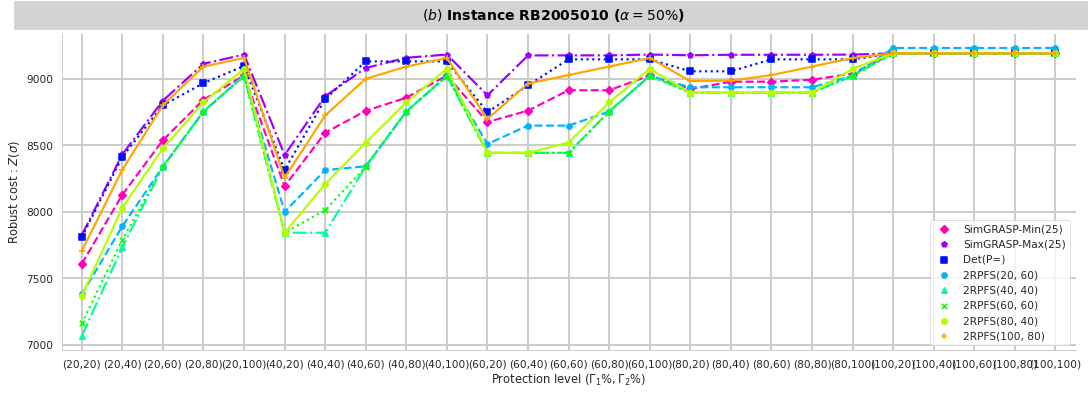

In [47]:
####filename = 'RB0105005.txt'
#filename = 'RB0105010.txt'  # Large Uncertainty range: 'RB0505006.txt', 'RB0505003.txt', 'RB1005003.txt', 'RB1005006.txt', 'RB1005008.txt', 'RB1005009.txt'
#filename = 'RB1505001.txt'  # 'RB0205001.txt', 'RB0205003.txt', 'RB0205008.txt', 'RB0205009.txt', 'RB0505010.txt', 'RB0505009.txt'
# 'RB1505008.txt', 'RB1505007.txt', 'RB1505006.txt', 'RB1505004.txt', 'RB1505001.txt'
#filename = 'RB0505010.txt'  [(60,40),(20,100),(60,100),(80,100),(60,60),(40,20)]  ## (40,100), (100,100)
filename = 'RB2005010.txt'
n = 150
result_dict = dict()
result_dict['SimGRASP-Min(25)'] = df_ssgrasp_min_worstcost.sort_values(by=['RobCost_Gamma1', 'RobCost_Gamma2'])
result_dict['SimGRASP-Max(25)'] = df_ssgrasp_max_worstcost.sort_values(by=['RobCost_Gamma1', 'RobCost_Gamma2'])
result_dict['Det(P=)'] = df_det_d0.sort_values(by=['RobCost_Gamma1', 'RobCost_Gamma2'])

include_list = [(100,80), (20,60), (80,40), (60,60), (40,40)]  # (20,20), (20,80), (40,20), (40,40)  # 'RB1505007.txt'
for g1 in [20, 40, 60, 80, 100]:
    for g2 in [20, 40, 60, 80, 100]:
        if (g1,g2) in include_list:  # str(int(g1*n/100)) + ', ' + str(int(g2*n/100))
            result_dict['2RPFS(' + str(g1) + ', ' + str(g2) + ')'] = df_2rpfs_robustcost_paper[(df_2rpfs_robustcost_paper['Gamma1'] == g1) & (df_2rpfs_robustcost_paper['Gamma2'] == g2)]
#result_dict['2RPFS(10,10)'] = df_det_d100
plot_worstcase_comparison(n, filename, 'hsv_r', result_dict, r'$(b)$', r'($\alpha=50\%$)', enable_markers=True)

#### Now let's check which robust solutions shown above have the same value, regardless of (RobCost_Gamma1, RobCost_Gamma2)

Before (RobCost_Gamma1, RobCost_Gamma2) = (60,20), robust solutions Rob(20,60) and Rob(40,80) are almost equivalent. They present the same robust costs, except when (RobCost_Gamma1, RobCost_Gamma2) = (20,40). 


In [48]:
df_ = df_2rpfs_robustcost_paper[(df_2rpfs_robustcost_paper['instance_name'] == filename)]
df_['budget_Gamma'] = df_['Gamma1'].astype(str) + ' ' + df_['Gamma2'].astype(str)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):   # (60,100)
    display(df_[df_['budget_Gamma'].isin(['20 60', '40 80'])].sort_values(['RobCost_Gamma1', 'RobCost_Gamma2']))

,n,m,alpha,instance_name,cmax_star,Gamma1,Gamma2,RobCost_Gamma,RobCost_worstcase,RobCost_Gamma1,RobCost_Gamma2,budget_Gamma
27,200,2,50,RB2005010.txt,8339.5,20,60,20 20,7378.5,20,20,20 60
33,200,2,50,RB2005010.txt,8754.0,40,80,20 20,7573.5,20,20,40 80
78,200,2,50,RB2005010.txt,8339.5,20,60,20 40,7892.5,20,40,20 60
84,200,2,50,RB2005010.txt,8754.0,40,80,20 40,8066.0,20,40,40 80
129,200,2,50,RB2005010.txt,8339.5,20,60,20 60,8339.5,20,60,20 60
135,200,2,50,RB2005010.txt,8754.0,40,80,20 60,8404.5,20,60,40 80
180,200,2,50,RB2005010.txt,8339.5,20,60,20 80,8754.0,20,80,20 60
186,200,2,50,RB2005010.txt,8754.0,40,80,20 80,8754.0,20,80,40 80
231,200,2,50,RB2005010.txt,8339.5,20,60,20 100,9022.5,20,100,20 60
237,200,2,50,RB2005010.txt,8754.0,40,80,20 100,9022.5,20,100,40 80


After (RobCost_Gamma1, RobCost_Gamma2) = (60,20) and beyond, all three robust solutions shown on the graph are equivalent (e.g. they present the same robust cost. 

In [49]:
df_ = df_2rpfs_robustcost_paper[(df_2rpfs_robustcost_paper['instance_name'] == filename)]
df_['budget_Gamma'] = df_['Gamma1'].astype(str) + ' ' + df_['Gamma2'].astype(str)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):   # (60,100)
    display(df_[df_['budget_Gamma'].isin(['20 40', '20 60', '40 80'])].sort_values(['RobCost_Gamma1', 'RobCost_Gamma2']))

,n,m,alpha,instance_name,cmax_star,Gamma1,Gamma2,RobCost_Gamma,RobCost_worstcase,RobCost_Gamma1,RobCost_Gamma2,budget_Gamma
26,200,2,50,RB2005010.txt,7732.5,20,40,20 20,7157.5,20,20,20 40
27,200,2,50,RB2005010.txt,8339.5,20,60,20 20,7378.5,20,20,20 60
33,200,2,50,RB2005010.txt,8754.0,40,80,20 20,7573.5,20,20,40 80
77,200,2,50,RB2005010.txt,7732.5,20,40,20 40,7732.5,20,40,20 40
78,200,2,50,RB2005010.txt,8339.5,20,60,20 40,7892.5,20,40,20 60
84,200,2,50,RB2005010.txt,8754.0,40,80,20 40,8066.0,20,40,40 80
128,200,2,50,RB2005010.txt,7732.5,20,40,20 60,8339.5,20,60,20 40
129,200,2,50,RB2005010.txt,8339.5,20,60,20 60,8339.5,20,60,20 60
135,200,2,50,RB2005010.txt,8754.0,40,80,20 60,8404.5,20,60,40 80
179,200,2,50,RB2005010.txt,7732.5,20,40,20 80,8754.0,20,80,20 40


In [50]:
df_ = df_2rpfs_robustcost_paper[(df_2rpfs_robustcost_paper['instance_name'] == filename)]
df_['budget_Gamma'] = df_['Gamma1'].astype(str) + ' ' + df_['Gamma2'].astype(str)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):   # (60,100)
    display(df_[df_['budget_Gamma'].isin(['60 60'])].sort_values(['RobCost_Gamma1', 'RobCost_Gamma2']))

,n,m,alpha,instance_name,cmax_star,Gamma1,Gamma2,RobCost_Gamma,RobCost_worstcase,RobCost_Gamma1,RobCost_Gamma2,budget_Gamma
38,200,2,50,RB2005010.txt,8443.5,60,60,20 20,7160.5,20,20,60 60
89,200,2,50,RB2005010.txt,8443.5,60,60,20 40,7788.5,20,40,60 60
140,200,2,50,RB2005010.txt,8443.5,60,60,20 60,8339.5,20,60,60 60
191,200,2,50,RB2005010.txt,8443.5,60,60,20 80,8754.0,20,80,60 60
242,200,2,50,RB2005010.txt,8443.5,60,60,20 100,9022.5,20,100,60 60
293,200,2,50,RB2005010.txt,8443.5,60,60,40 20,7842.5,40,20,60 60
344,200,2,50,RB2005010.txt,8443.5,60,60,40 40,8012.5,40,40,60 60
395,200,2,50,RB2005010.txt,8443.5,60,60,40 60,8339.5,40,60,60 60
446,200,2,50,RB2005010.txt,8443.5,60,60,40 80,8754.0,40,80,60 60
497,200,2,50,RB2005010.txt,8443.5,60,60,40 100,9022.5,40,100,60 60


In [51]:
def get_instance_solution_info(df_rpfs, instance_name):
    return df_rpfs[(df_rpfs['instance_name'] == instance_name)][['Gamma1', 'Gamma2', 'is_optimal', 
                                                                   'validated', 'gap', 'time', 'optimal']]

# Plotting Monte Carlo Simulation results

Simulations were undertaken for 3 probability distributions: lognormal, triangular and uniform.

In [52]:
sim_results_folder_det_rob = os.path.join(os.path.abspath('..'), 'pfsp_experiments', 'montecarlo_sim_2rpfs', 'new_simulation')
                                  #'2020_06_29-22_29_49-4752183a-ba47-11ea-1f13-43a2532b2fa8')
sim_results_folder_simgrasp = sim_results_folder_det_rob
sim_results_folder_ssgrasp = os.path.join(os.path.abspath('..'), 'pfsp_experiments', 'SimGRASP_Ying_outputs')
print('[Det, Rob] Using simulation results folder: ', sim_results_folder_det_rob)
print('[SimGRASP] Using simulation results folder: ', sim_results_folder_simgrasp)
print('[SSGRASP] Using simulation results folder: ', sim_results_folder_ssgrasp)

[Det, Rob] Using simulation results folder:  /public/doutorado_files/pfsp_experiments/montecarlo_sim_2rpfs/new_simulation
[SimGRASP] Using simulation results folder:  /public/doutorado_files/pfsp_experiments/montecarlo_sim_2rpfs/new_simulation
[SSGRASP] Using simulation results folder:  /public/doutorado_files/pfsp_experiments/SimGRASP_Ying_outputs


In [53]:
def read_simulation_result_csv_to_series(filename):
    #print('Reading file: ', filename)
    df = pd.read_csv(filename, index_col=False, header=0, names=['Makespan'])
    series = df['Makespan'] # here we convert the DataFrame into a Series
    return series

In [54]:
def read_budget_simulation_results_to_series(root_folder, instance_name, alpha, distribution, gamma1, gamma2, num_iter=10000):
    folder = os.path.join(root_folder, 'robust_pfsp', distribution, 'alpha{}%'.format(alpha))
    filename = 'MCS_rob_{}_{}_{}_{}_{}_iter{}.txt.gz'.format(gamma1, gamma2, instance_name, alpha, distribution, num_iter)
    filepath = os.path.join(folder, filename)
    return read_simulation_result_csv_to_series(filepath)

In [55]:
def read_deterministic_simulation_results_to_series(root_folder, instance_name, alpha, distribution, perc_variation, num_iter=10000):
    folder = os.path.join(root_folder, 'deterministic_pfsp', distribution, 'alpha{}%'.format(alpha))
    filename = 'MCS_det{}_{}_{}_{}_iter{}.txt.gz'.format(perc_variation, instance_name, alpha, distribution, num_iter)
    filepath = os.path.join(folder, filename)
    return read_simulation_result_csv_to_series(filepath)

In [56]:
def read_ssgrasp_raw_outputs_to_series(filepath):
    with gzip.open(filepath, 'rt') as content_file:
        content = content_file.read()
        content = content[content.find('STOCH')+5:]
        #content = content[content.find('DET')+3:content.find('STOCH')]
        content = content.replace("\n", "")
        s = pd.Series([float(x) for x in content.split()], name='Makespan')
        #s.to_csv(os.path.join(os.getcwd(), "temp.csv"), index=False, header=0)
        return s

In [57]:
def read_stochastic_simulation_results_to_series(root_folder, instance_name, alpha, distribution, raw=True, num_iter=10000):
    if raw:  # RB0105001_10_2_t_1.0_0.1_124341_outputsList.txt
        m = 2
        n = int(instance_name[2:5])
        grasp_instance_name = 'RB{}50{}'.format(instance_name[2:5], instance_name[7:9])
        filename = '{}_{}_{}_t_{:.1f}_{:.1f}_*_outputsList.txt.gz'.format(grasp_instance_name, n, m, 1.0, alpha / 100)
        files = glob.glob(os.path.join(root_folder, filename))
        series_list = []
        for filepath in files:
            series_list.append(read_ssgrasp_raw_outputs_to_series(filepath))
        result = pd.concat(series_list)
        return result
    else:
        folder = os.path.join(root_folder, 'simgrasp', distribution, 'alpha{}%'.format(alpha))
        filename = 'MCS_SimGRASP_{}_{}_{}_iter{}.txt.gz'.format(instance_name, alpha, distribution, num_iter)
        filepath = os.path.join(folder, filename)
        return read_simulation_result_csv_to_series(filepath)

In [58]:
def plot_violin_compare_distributions(df, instance_name, ax, seq, distribution, palette="Blues_d"):
    # https://towardsdatascience.com/violin-plots-explained-fb1d115e023d
    #a4_dims = (11.7, 8.27)
    #plt.figure(figsize=a4_dims)
    with sns.axes_style("whitegrid"):
        #style.use('ggplot')
        sns.set_context("paper", rc={"grid.linewidth": 2, "xtick.major.pad": 11})  # font_scale=1.2, 
        ax = sns.violinplot(ax=ax,y="Makespan", x="Method",   # x="Makespan", y="Method", 
                               #hue="Method", #kind="violin", 
                               style="Method", 
                     data=df, palette=palette, 
                     scale="area", cut=0, inner='box', 
                     # width=0.8, showmeans=True, showextrema=True, showmedians=True
                     height=10, # make the plot 5 units high
                     aspect=2.5) # height should be three times width
        ax.set_xticklabels(
            ax.get_xticklabels(), 
            rotation=45, 
            #horizontalalignment='right',
            fontweight='light',
            fontsize='large'
        )
        # Set Background color: https://stackoverflow.com/questions/25238442/setting-plot-background-colour-in-seaborn
        ax.set_facecolor('#f0f0f0')
        instance_name = instance_name[:instance_name.rfind('.txt')]
        ax.set_title('Simulation result from {} distribution'.format(distribution))
        if seq == 0:
            ax.set_ylabel('Makespan')
        else:
            ax.set_ylabel('')
        ax.set_xlabel('Solution Method')
        # Draw interval grid lines
        ax.grid(which='major', axis='x')
        ax.grid(which='minor', axis='y')
        #plt.set_title('Instance '+instance_name)
        #plt.show()
        #ax.get_figure().savefig(os.path.join(outputfolder_graph, 'violin_{}.pdf'.format(instance_name)))
        #display(sns.plotting_context())
        #chart.savefig(os.path.join(outputfolder_graph, 'violin_{}.pgf'.format(instance_name)))

In [59]:
def plot_kde_compare_distributions(dict_s, instance_name, ax, seq, distribution, palette):
    #a4_dims = (11.7, 8.27)
    #plt.figure(figsize=a4_dims)
    #print('Number os series to plot: ' + str(len(dict_s.keys())))
    marker = ['*', '+', 'o', 'x', '^', '8', 's', 'p', 'D', 'V', 'A', 'T']
    markers = [marker[i] for i in range(len(dict_s.keys()))]
    linestyle = ['--', '-.', ':', 'dashed', 'dashdot', 'dotted', 'solid', '-', ' ', '', 'None']
    # New line styles > 12
    # https://stackoverflow.com/questions/33337989/how-to-draw-more-type-of-lines-in-matplotlib/33338727
    linestyles = [linestyle[i] for i in range(len(dict_s.keys()))]
    with sns.axes_style("whitegrid"):
        #style.use('ggplot')
        #sns.set_style("whitegrid")
        sns.set(style="white", palette=palette) #, color_codes=True)
        #sns.set_palette(palette, 9, 0.8)
        sns.set_context("notebook", rc={"grid.linewidth": 2, "xtick.major.pad": 11})  # font_scale=1.2, 
        i = 0
        for method, series in dict_s.items():
            chart = sns.distplot(series, label=method, kde=True, hist=False, ax=ax, 
                         vertical=False, kde_kws=dict(ls=linestyle[i],dashes=linestyle_tuple[i][1][1]))  
            # markers=markers, 
            i += 1
        # Set Background color: https://stackoverflow.com/questions/25238442/setting-plot-background-colour-in-seaborn
        #chart.set_facecolor('#ffffff')
        ax.set_title('Simulation result from {} distribution'.format(distribution))
        ax.legend(loc='upper right', bbox_to_anchor=(1.10, 1.0), ncol=1)
        all_fonts_size = 12
        if seq == 0:
            ax.set_ylabel('Probability Distribution', fontsize=all_fonts_size)
        ax.set_xlabel('Makespan', fontsize=all_fonts_size)
        ax.tick_params(labelsize=all_fonts_size)
        ax.grid(which='major', axis='x')
        ax.grid(which='minor', axis='y')
        #plt.show()
        #chart.get_figure().savefig(os.path.join(outputfolder_graph, 'kde_{}.pdf'.format(instance_name)))
        #chart.savefig(os.path.join(outputfolder_graph, 'kde_{}.pgf'.format(instance_name)))

In [60]:
def plot_simulation_comparison(sim_results_folder_det_rob, sim_results_folder_simgrasp, instance_name, prefix, suffix, 
                               palette, include_list=[], graph_type="violin", num_iter=10000):
    # https://towardsdatascience.com/violin-plots-explained-fb1d115e023d
    a4_dims = (15, 5)
    #plt.figure(figsize=a4_dims)
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=a4_dims)
    #sns.set_style("whitegrid")
    for d, distribution in enumerate(['lognormal', 'uniform', 'triangular']):
        alpha = int(instance_name[5:7])
        simulated_solutions_dict = dict()
        simulated_solutions_dict['Det(P=)'] = read_deterministic_simulation_results_to_series(sim_results_folder_det_rob, 
                                                                                               instance_name, 
                                                                                               alpha, distribution, 0,
                                                                                                num_iter=num_iter)
        simulated_solutions_dict['Det(P-)'] = read_deterministic_simulation_results_to_series(sim_results_folder_det_rob, 
                                                                                               instance_name, 
                                                                                               alpha, distribution, -100,
                                                                                                num_iter=num_iter)

        for gamma1 in [20, 40, 60, 80, 100]:
            for gamma2 in [20, 40, 60, 80, 100]:
                simulated_solutions_dict['2RPFS({},{})'.format(gamma1, gamma2)] = read_budget_simulation_results_to_series(
                                                                                sim_results_folder_det_rob, 
                                                                                filename, alpha, distribution, gamma1, gamma2,
                                                                                num_iter=num_iter)
        #simulated_solutions_dict['SimGRASP(MCS_Java)'] = read_stochastic_simulation_results_to_series(sim_results_folder_ssgrasp, 
        #                                                                                    instance_name, alpha, 
        #                                                                                    distribution, True)
        simulated_solutions_dict['SimGRASP'] = read_stochastic_simulation_results_to_series(sim_results_folder_simgrasp, 
                                                                                            instance_name, alpha, 
                                                                                            distribution, False,
                                                                                            num_iter=num_iter)
        df_list = []
        filtered_solutions_dict = dict()
        for key, s_i in simulated_solutions_dict.items():
            df_i = s_i.to_frame()
            df_i['Method'] = key
            df_i['Distribution'] = distribution
            if key in include_list:
                df_list.append(df_i)
                filtered_solutions_dict[key] = s_i
        df = pd.concat(df_list)
        if graph_type == 'violin':
            plot_violin_compare_distributions(df, instance_name, axs[d], d, distribution, palette=palette)
        else:  # kde plot
            plot_kde_compare_distributions(filtered_solutions_dict, instance_name, axs[d], d, distribution, palette=palette)
        #axs[d].yaxis.tick_right()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    instance_name = instance_name[:instance_name.rfind('.txt')]
    # ============== Special trick to make the suptitle with large backgrounds
    # register the custom style
    BoxStyle._style_list["ext"] = ExtendedTextBox
    title = plt.suptitle(prefix + ' Instance ' + instance_name + ' ' + suffix, fontsize=12, fontweight='bold', 
                         position=(.5, 0.99), backgroundcolor='#d3d3d3', color='black')
    # set the box style of the title text box to our custom box
    bb = title.get_bbox_patch()
    def resize(event):
        # use the figure width as width of the text box 
        bb.set_boxstyle("ext", pad=0.4, width=fig.get_size_inches()[0]*fig.dpi )
    resize(None)
    # =========================================================================
    if graph_type == 'violin':
        fig.savefig(os.path.join(outputfolder_graph, 'violinplot_{}.pdf'.format(instance_name)))
    else:  # kde plot
        fig.savefig(os.path.join(outputfolder_graph, 'kdeplot_{}.pdf'.format(instance_name)))

### Expected cost : Small Uncertainty Range Instance - Example 

Alpha = 20% and n = 10

TODO Traçar uma linha dentro do gráfico do violin plot, demarcando o valor do worst-case makespan (dado pelo robusto)

Agora vamos traçar um gráfico de KDE com a distribuição de valores de cada simulação.

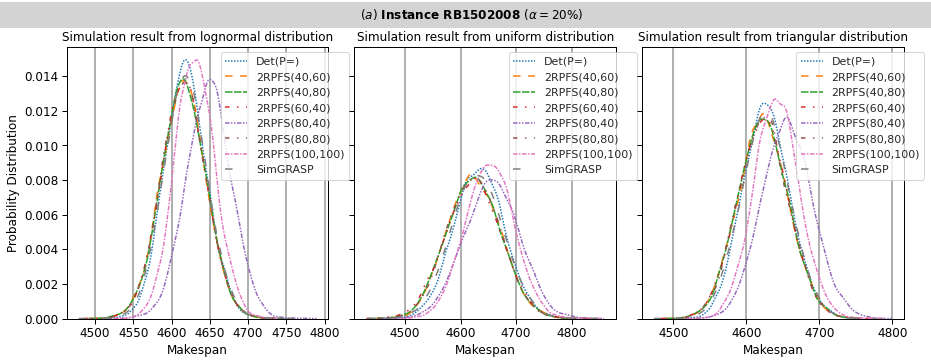

In [61]:
filename = 'RB1502008.txt'
#filename = 'RB0102005.txt'  # budgets (from previous worstcase analysis): '20 60', '20 80', '40 80', '40 100', '60 100'
# removed: '2RPFS(10,60)', '2RPFS(10,80)', 
include_list=['Det(P=)', 'SimGRASP', '2RPFS(40,80)', '2RPFS(40,80)', '2RPFS(80,80)', '2RPFS(80,40)', '2RPFS(40,60)', '2RPFS(60,40)', '2RPFS(100,100)']
plot_simulation_comparison(sim_results_folder_det_rob, sim_results_folder_det_rob, filename, r'$(a)$', r'$(\alpha=20\%)$',
                           graph_type='kde',
                           # budgets (from previous worstcase analysis): '20 60', '20 80', '40 80', '40 100', '60 100'
                           include_list=include_list,
                           palette='hsv') # Dark2, Set3, Paired_r

**Analysis:** 

Regarding the small uncertainty instance, the expected makespan performance of 2RPFS(40,60), as well as 2RPFS(40,80), 2RPFS(60,40), 2RPFS(80,40) and 2RPFS(80,80), are really good, equivalent to SimGRASP. However, the protection against worst-case scenarios vary considerably, according to the budget parameters. The best performing solutions, from smallest to largest robust cost, are: 2RPFS(80,40), 2RPFS(60,40), SimGRASP-Min(25), 2RPFS(40,60), 2RPFS(40,80) and 2RPFS(80,80). 
%, protect much more against worst-case costs. 
In particular, even though 2RPFS(40,20) has very good expected makespan values, its $\Gamma$ parameter combination does not offer the best protection against worst-case costs, when compared to other robust solutions. 

### Expected cost : Large Uncertainty Range Instance - Example 

Alpha = 50% and n = 10

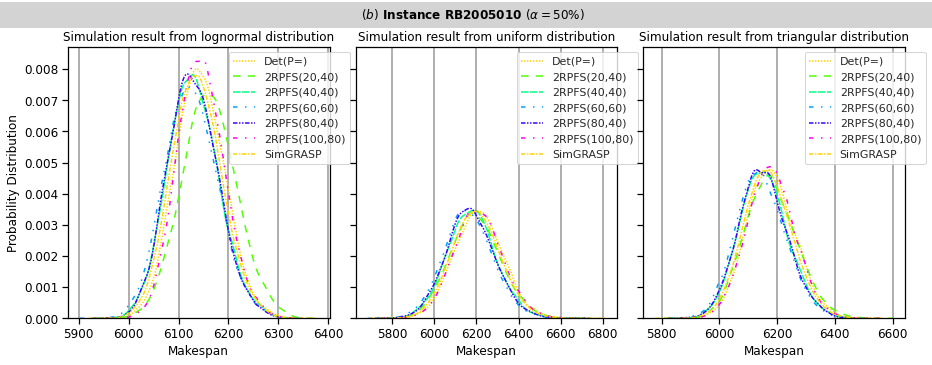

In [62]:
###filename = 'RB0105005.txt'
filename = 'RB2005010.txt'  # include_list = (100,80), (20,60), (80,40), (60,60)   ### '2RPFS(40,20)', '2RPFS(60,40)'
include_list = ['Det(P=)', 'SimGRASP', '2RPFS(20,40)', '2RPFS(40,40)', '2RPFS(60,60)', '2RPFS(80,40)', '2RPFS(100,80)']  # '(20,20)','(100,100)' # 'RB1505007.txt'
plot_simulation_comparison(sim_results_folder_det_rob, sim_results_folder_det_rob, filename, r'$(b)$', r'$(\alpha=50\%)$',
                           graph_type='kde',
                          # budgets (from previous worstcase analysis): [(20,40), (20,60), (40,80)]
                          include_list=include_list,
                          palette='Set1')   # Paired, hsv, ***Set1

When analyzing the large uncertainty instance, several robust solutions present expected makespan performance quite similar to SimGRASP: 2RPFS(40,20), 2RPFS(40,40), 2RPFS(60,40), 2RPFS(60,60) and 2RPFS(100,80). However, only the first four provide better protection against worst-case costs. Even though 2RPFS(100,80) presents very good expected makespan values, its robust costs (worst-case performance) is suboptimal for several values of $\Gamma_{1}$ and $\Gamma_{2}$, as can be seen in Figure x(b), from the previous analysis. 
In the present graph, we also include the results from the solution method with the highest expected makespan value: Rob(20,80). 

# Monte Carlo Simulation results - Summary table

In [63]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [64]:
def table_simulation_comparison(sim_results_folder_det_rob, sim_results_folder_ssgrasp, instance_name, prefix, suffix, 
                               save_csv=False, include_results=None, num_iter=10000):
    grouped_df_list = []
    grouped_df_list_tableau = []
    for d, distribution in enumerate(['lognormal','normal', 'uniform', 'triangular']):
        alpha = int(instance_name[5:7])
        simulated_solutions_dict = dict()
        for gamma1 in [20, 40, 60, 80, 100]:
            for gamma2 in [20, 40, 60, 80, 100]:
                simulated_solutions_dict[('2RPFS({},{})'.format(gamma1, gamma2), gamma1, gamma2)] = read_budget_simulation_results_to_series(
                                                                            sim_results_folder_det_rob, 
                                                                            filename, alpha, distribution, gamma1, gamma2,
                                                                            num_iter=num_iter)
        #simulated_solutions_dict[('Det(100)', 200, 200)] = read_deterministic_simulation_results_to_series(sim_results_folder_det_rob, 
        #                                                                                       instance_name, 
        #                                                                                       alpha, distribution, 100,
        #                                                                                        num_iter=num_iter)
        simulated_solutions_dict[('Det_P_mid', 200, 200)] = read_deterministic_simulation_results_to_series(sim_results_folder_det_rob, 
                                                                                               instance_name, 
                                                                                               alpha, distribution, 0,
                                                                                                num_iter=num_iter)
        simulated_solutions_dict[('Det_P_minus', 200, 200)] = read_deterministic_simulation_results_to_series(sim_results_folder_det_rob, 
                                                                                               instance_name, 
                                                                                               alpha, distribution, -100,
                                                                                                num_iter=num_iter)
        simulated_solutions_dict[('SimGRASP', 200, 200)] = read_stochastic_simulation_results_to_series(sim_results_folder_simgrasp, 
                                                                                            instance_name, alpha, 
                                                                                            distribution, False,
                                                                                            num_iter=num_iter)
        #simulated_solutions_dict[('SimGRASP(MCS_Java)', 200, 200)] = read_stochastic_simulation_results_to_series(sim_results_folder_ssgrasp, 
        #                                                                                    instance_name, alpha, 
        #                                                                                    distribution, True)
        df_list = []
        filtered_solutions_dict = dict()
        for key, s_i in simulated_solutions_dict.items():
            df_i = s_i.to_frame()
            df_i['Method'] = key[0]
            df_i['Gamma1'] = key[1]
            df_i['Gamma2'] = key[2]
            df_i['Distribution'] = distribution
            if include_results is None or key[0] in include_results:
                df_list.append(df_i)
                filtered_solutions_dict[key] = s_i
        df = pd.concat(df_list)
        df_grouped = df.copy()
        df_grouped = df_grouped.groupby(['Method', 'Distribution']).agg({'Makespan':[np.mean, np.std, np.max, percentile(95), \
                                                                             percentile(99), 'count']})
        df_grouped.columns = df_grouped.columns.droplevel()
        df_grouped = df_grouped.reset_index()
        value_columns = ['mean', 'std', 'percentile_95', 'percentile_99', 'amax', 'count']
        # Melt the value columns -> key, value style
        df_grouped = pd.melt(df_grouped, id_vars=['Method', 'Distribution'], value_vars=value_columns)
        df_grouped['instance'] = instance_name
        # For each variable, mark the smallest value (among all methods) with a binary marker in an extra column
        df_grouped['is_min'] = df_grouped['value'] == df_grouped.groupby(['Distribution', 'variable'])['value'] \
                                                                                  .transform('min')
        #print(df_grouped)
        #df_grouped.columns = df_grouped.columns.droplevel(0)
        grouped_df_list_tableau.append(df_grouped)
        #df_grouped.rename(columns=dict(zip(df_grouped.columns[[0, 1, 2, 3, 4]], labels)),inplace=True)
        
        df = df.rename(columns={"Makespan": distribution})
        table = pd.pivot_table(df, values=[distribution], index=['Gamma1', 'Gamma2', 'Method'], columns=['Distribution'], \
                           aggfunc={distribution: [np.mean, np.std, np.max, percentile(95), percentile(99),'count']})
        table.columns = table.columns.droplevel(2)
        # Re-order table columns
        column_order = [(distribution,'mean'), (distribution,'std'), (distribution,'percentile_95'), \
                        (distribution,'percentile_99'), (distribution,'amax'), (distribution,'count')]
        table = table.reindex(column_order, axis=1)
        # Renaming the pivot table columns to improve presentation
        #labels = [r'$E(\varphi(\sigma))$', r'$SD(\varphi(\sigma))$', r'$\varphi_{0.95}(\sigma)$', \
        #          r'$\varphi_{0.99}(\sigma)$', r'$\varphi_{max}(\sigma)$']
        #table = table.rename(columns={"mean": labels[0], "std": labels[1], "percentile_95": labels[2], \
        #                              'percentile_99': labels[3], 'amax': labels[4]}, level=1, errors="raise")
        table.columns.set_levels(['Results from {} distribution'.format(distribution)],level=0,inplace=True)
        table = table.round(1)
        grouped_df_list.append(table.copy())
        #print(table)
    # end for
    df_to_tableau = pd.concat(grouped_df_list_tableau)
    df_all = pd.concat(grouped_df_list, join='inner', axis=1)
    print(df_all)
    #print(df_all.to_latex(escape=False, float_format='%.1f', sparsify=True, label='tab:simresults_{}'.format(instance_name), 
    #                      caption='Summary of the simulation for deterministic, 2RPFS and SimGRASP solution methods' + \
    #                      ' from lognormal, triangular and uniform distributions.'))
    if save_csv:
        df_all.to_csv(os.path.join(outputfolder, 'table_simulation_results_{}.csv'.format(instance_name)), sep=';')
        df_to_tableau.to_csv(os.path.join(outputfolder, 'stats_simulation_results_{}.csv'.format(instance_name)), sep=';', index=False)
    #sup_labels = ['Results from {} distribution'.format(dist) for dist in ['lognormal', 'symmetric triangular', 'uniform']]
    

### Small uncertainty range instance

In [65]:
filename = 'RB1502008.txt'
#table_simulation_comparison(sim_results_folder_det_rob, sim_results_folder_ssgrasp, filename, r'$(a)$', r'$(\alpha=20\%)$', save_csv=True)
table_simulation_comparison(sim_results_folder_det_rob, sim_results_folder_ssgrasp, filename, r'$(a)$', r'$(\alpha=20\%)$',
    #include_results=['2RPFS(100,100)', '2RPFS(100,60)', '2RPFS(100,80)', '2RPFS(20,20)', '2RPFS(20,40)', '2RPFS(40,40)', \
    #'2RPFS(40,60)', '2RPFS(40,80)', '2RPFS(60,20)', '2RPFS(60,40)', '2RPFS(60,80)', '2RPFS(80,40)', '2RPFS(80,80)', \
    #'Det', 'SimGRASP'], 
    save_csv=True, num_iter=10000)

                             Results from lognormal distribution        \
                                                            mean   std   
Gamma1 Gamma2 Method                                                     
20     20     2RPFS(20,20)                                4615.7  29.2   
       40     2RPFS(20,40)                                4615.5  29.2   
       60     2RPFS(20,60)                                4615.7  29.1   
       80     2RPFS(20,80)                                4635.7  26.6   
       100    2RPFS(20,100)                               4872.7  30.0   
40     20     2RPFS(40,20)                                4615.6  29.1   
       40     2RPFS(40,40)                                4615.7  29.1   
       60     2RPFS(40,60)                                4615.6  29.1   
       80     2RPFS(40,80)                                4615.7  29.1   
       100    2RPFS(40,100)                               4630.5  25.9   
60     20     2RPFS(60,20)            

### Large uncertainty range instance

In [66]:
# #filename = 'RB1501006.txt'  # Small Uncertainty range
#filename = 'RB1502008.txt' # 'RB1502001.txt', 'RB1502006.txt', 'RB1502009.txt', 'RB1502010.txt'
#filename = 'RB0505010.txt'
#filename = 'RB1505007.txt'
#filename = 'RB1505006.txt'
#filename = 'RB1505007.txt'
filename = 'RB2005010.txt'
#table_simulation_comparison(sim_results_folder_det_rob, sim_results_folder_ssgrasp, filename, r'$(b)$', r'$(\alpha=50\%)$', save_csv=True)
table_simulation_comparison(sim_results_folder_det_rob, sim_results_folder_ssgrasp, filename, r'$(b)$', r'$(\alpha=50\%)$',
                           #include_results=['2RPFS(100,80)', '2RPFS(20,20)', '2RPFS(20,40)', '2RPFS(40,20)', '2RPFS(40,40)', \
                           # '2RPFS(40,60)', '2RPFS(60,40)', '2RPFS(60,60)', '2RPFS(60,80)', '2RPFS(80,40)', '2RPFS(20,80)', \
                           # 'Det', 'SimGRASP'], 
                            save_csv=True) # , num_iter=1000000)

                             Results from lognormal distribution        \
                                                            mean   std   
Gamma1 Gamma2 Method                                                     
20     20     2RPFS(20,20)                                6125.6  52.4   
       40     2RPFS(20,40)                                6161.4  54.3   
       60     2RPFS(20,60)                                6151.5  53.8   
       80     2RPFS(20,80)                                6164.1  54.5   
       100    2RPFS(20,100)                               6211.5  54.9   
40     20     2RPFS(40,20)                                6125.6  52.5   
       40     2RPFS(40,40)                                6129.9  50.7   
       60     2RPFS(40,60)                                6142.7  53.4   
       80     2RPFS(40,80)                                6140.7  53.2   
       100    2RPFS(40,100)                               6234.3  54.4   
60     20     2RPFS(60,20)            

In [67]:
from plotly.figure_factory import create_distplot
x1 = np.random.randn(190)
x2 = np.random.randn(200)+1
x3 = np.random.randn(200)-1
x4 = np.random.randn(210)+2
hist_data = [x1, x2, x3, x4]
group_labels = ['2012', '2013', '2014', '2015']
fig = create_distplot(
    hist_data, group_labels, curve_type='normal',
    show_rug=False, bin_size=.4)

ModuleNotFoundError: No module named 'plotly'

https://plotly.com/python/v3/LaTeX/
https://plotly.github.io/plotly.py-docs/generated/plotly.figure_factory.create_distplot.html
https://www.kaggle.com/thebrownviking20/intermediate-visualization-tutorial-using-plotly


In [ ]:
fig.show()
fig.write_image("images/fig1.pdf")